### Step 1 : Import Modules/Packages



In [2]:
try :

  # Third-Party Packages

  ## data-manipulation packages
  import pandas as pd
  import numpy as np

  ## model-building packages

  from fast_ml.model_development import train_valid_test_split, all_classifiers, execute_model
  from fast_ml.model_evaluation import get_fi, threshold_evaluation
  from fast_ml import eda
  
  from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
  from sklearn.model_selection import GridSearchCV, train_test_split
  from sklearn.ensemble import RandomForestClassifier
  
  from xgboost import XGBClassifier

  ## data-visualization Packages
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Built-In Packages
  from itertools import combinations
  from pylab import rcParams
  import pickle

except ImportError as _ie:
  print(_ie)

### Step 2 : Define Constant Variables

In [3]:
# Matplotlib default settings

plt.rcParams.update({
  "figure.figsize": (15,6),
  "figure.dpi": 100,
  "lines.linewidth": .5,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": 'true',
  "axes.facecolor": "#eeeeee",
  "axes.labelsize": "large",
  "axes.grid": 'true',
  "axes.linewidth": 1,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path",
  "grid.linewidth": 0.5,
  "grid.alpha": 1.0
})

SEED = 2021

RAW_CSV_FILEPATH = './data_interview_test.csv'
INTERIM_DATASET_FILEPATH = './interim_dataset.csv'

### Step 3 : Load the raw dataset

In [4]:
def read_data(filepath: str, _sep: str) -> pd.DataFrame:
  """
  Read csv data

  Return
  ------
  pd.DataFrame
  """
  return pd.read_csv(filepath, sep = _sep)
  
raw_data_df = read_data(filepath = RAW_CSV_FILEPATH, _sep = ':')

**Preview loaded raw dataset**

In [5]:
"""Top Five samples of the raw dataset"""
raw_data_df.head(5)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
"""Dimension of the raw dataset"""
raw_data_df.shape

(12034, 14)

In [7]:
"""Check of Null Values"""
raw_data_df.isnull().sum()

receipt_id                 0
company_id                 0
matched_transaction_id     0
feature_transaction_id     0
DateMappingMatch           0
AmountMappingMatch         0
DescriptionMatch           0
DifferentPredictedTime     0
TimeMappingMatch           0
PredictedNameMatch         0
ShortNameMatch             0
DifferentPredictedDate     0
PredictedAmountMatch       0
PredictedTimeCloseMatch    0
dtype: int64

### Step 4 : Create Target Varibale

Use **Supervised Machine Learning** approach to solve the problem. **Supervised Machine Learning** solutions have  -
- features
- label/target

The training is done on a sample of dataset and testing on another sample of the dataset.

The raw dataset does not contain target variable. Hence, we have to create target variable using matching logic.
The target variable return 2 unique values i.e.

*   **0** : Not Matched
*   **1** : Matched

**Logic :**

```
if 'matched_transaction_id' == 'feature_transaction_id' then
    return 1
else
    return 0
```





In [8]:
def create_target(raw_data: pd.DataFrame)-> pd.DataFrame:
  """
  Create Target Variable
  Return
  ------
  pd.DataFrame
  """
  return (raw_data.matched_transaction_id == raw_data.feature_transaction_id).astype(int)

interim_data_df = raw_data_df.copy()
interim_data_df['target'] = create_target(raw_data = raw_data_df)

interim_data_df.head(5)


,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [9]:
"""Save the interim dataset"""
interim_data_df.to_csv(INTERIM_DATASET_FILEPATH)

**Quick Summary of the interim dataset**

In [10]:
def data_summary(data_df: pd.DataFrame) -> pd.DataFrame:
  """
  Summary of the dataset
  Return
  ------
  pd.DataFrame
  """
  return eda.df_info(data_df)

data_summary(data_df = interim_data_df)

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
receipt_id,object,Categorical,1155,"[10,000, 10,001, 10,002, 10,003, 10,004, 10,00...",0,0
company_id,int64,Numerical,5,"[10000, 20000, 30000, 40000, 50000]",0,0
matched_transaction_id,object,Categorical,1155,"[10,468, 10,605, 10,286, 10,412, 10,413, 10,47...",0,0
feature_transaction_id,object,Categorical,2132,"[10,000, 10,001, 10,003, 10,004, 10,005, 10,00...",0,0
DateMappingMatch,float64,Numerical,11,"[0.0, 0.9, 0.95, 0.55, 0.85, 0.65, 1.0, 0.75, ...",0,0
AmountMappingMatch,float64,Numerical,5,"[0.0, 0.4, 0.7, 0.6, 0.9]",0,0
DescriptionMatch,float64,Numerical,5,"[0.0, 0.6, 0.4, 0.8, 0.2]",0,0
DifferentPredictedTime,float64,Numerical,2,"[1.0, 0.0]",0,0
TimeMappingMatch,float64,Numerical,2,"[0.0, 1.0]",0,0
PredictedNameMatch,float64,Numerical,5,"[0.0, 0.8, 0.6, 0.4, 0.2]",0,0


In [11]:
"""Target Variable data distribution"""
def target_summary(data_df: pd.DataFrame, _target_col_name) -> pd.DataFrame:

  _info = list()
  _info.append(data_df[_target_col_name].value_counts().to_dict())
  _info.append(data_df[_target_col_name].value_counts(normalize=True).to_dict())

  return pd.DataFrame(data = _info, index=['count', '%age'])
  

target_summary(data_df = interim_data_df, _target_col_name = 'target')



,0,1
count,11177.000000,857.000000
%age,0.928785,0.071215


**Conclusion**

Above analysis shows the dataset is highly biased towards `0` target varibale i.e. Not Matched. 

- 93% of dataset belong to target `0` i.e. Not Matched
- 7% of dataset belong to target `1` i.e. Matched

Company & Receipt Distribution

In [12]:
"""Company Level Receipt that are matched vs not matched"""

def receipt_contigency_table(data_df: pd.DataFrame, col_list: list, _target_col_name: str):

  grp_data = data_df.groupby(by=col_list)[_target_col_name].max().reset_index()

  return pd.pivot_table(grp_data, index=col_list[0], columns=_target_col_name, aggfunc='count', margins=True, margins_name='Total')
  
receipt_summary = receipt_contigency_table(data_df = interim_data_df, 
                                           col_list = ['company_id', 'receipt_id'],
                                           _target_col_name = 'target')
receipt_summary

receipt_id           
target              0    1 Total
company_id                      
10000              52  154   206
20000              68  145   213
30000             120  250   370
40000              25  123   148
50000              33  185   218
Total             298  857  1155

### Step 5 : Exploratory Data Analysis

Let, start our observation by checking the average number of partial matches for each receipt_id

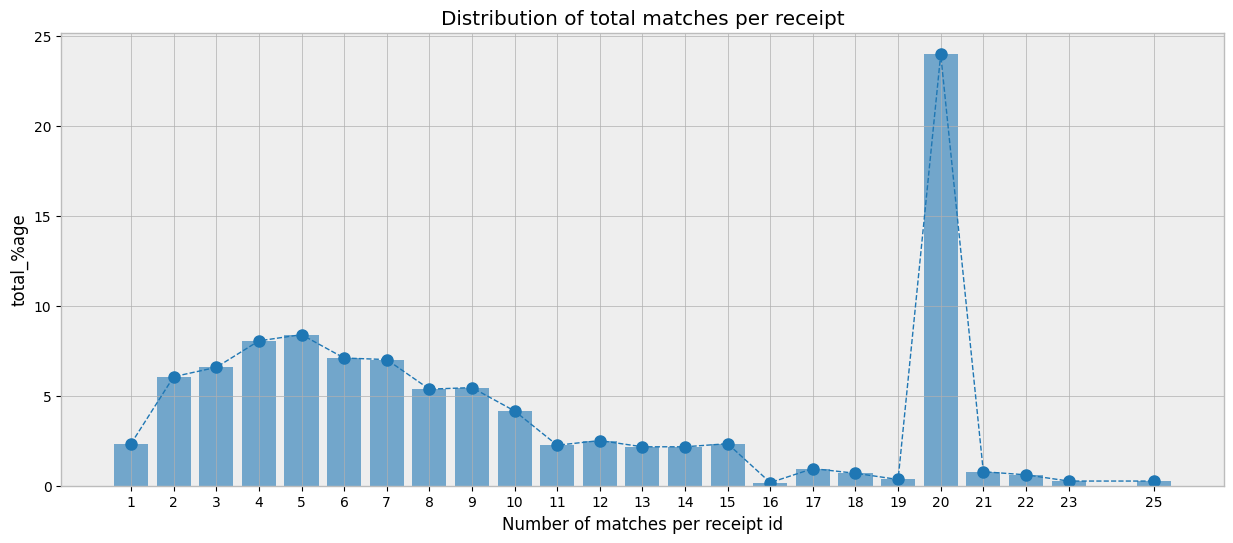

In [14]:
receipt_dist = 100*(interim_data_df['receipt_id'].value_counts().value_counts(normalize=True)).sort_index()

def plot_receipt_dist(data_df: pd.DataFrame):

  _x = data_df.index.tolist()
  _y = data_df.values.tolist()

  plt.bar(_x, _y, alpha=0.6, lw="2")
  plt.plot(_x, _y, marker='o', linestyle='dashed', linewidth=1, markersize=8)

  plt.xticks(_x)
  plt.xlabel("Number of matches per receipt id")
  plt.ylabel("total_%age")
  plt.title("Distribution of total matches per receipt")
  plt.show()

plot_receipt_dist(data_df = receipt_dist)

**Observation**

- More than 24% of the receipts ids have 20 partial matches, while a lot of receipts ids have lower density of matches

Our second observation will be on the distribution of features among matching transactions and unmatching transactions

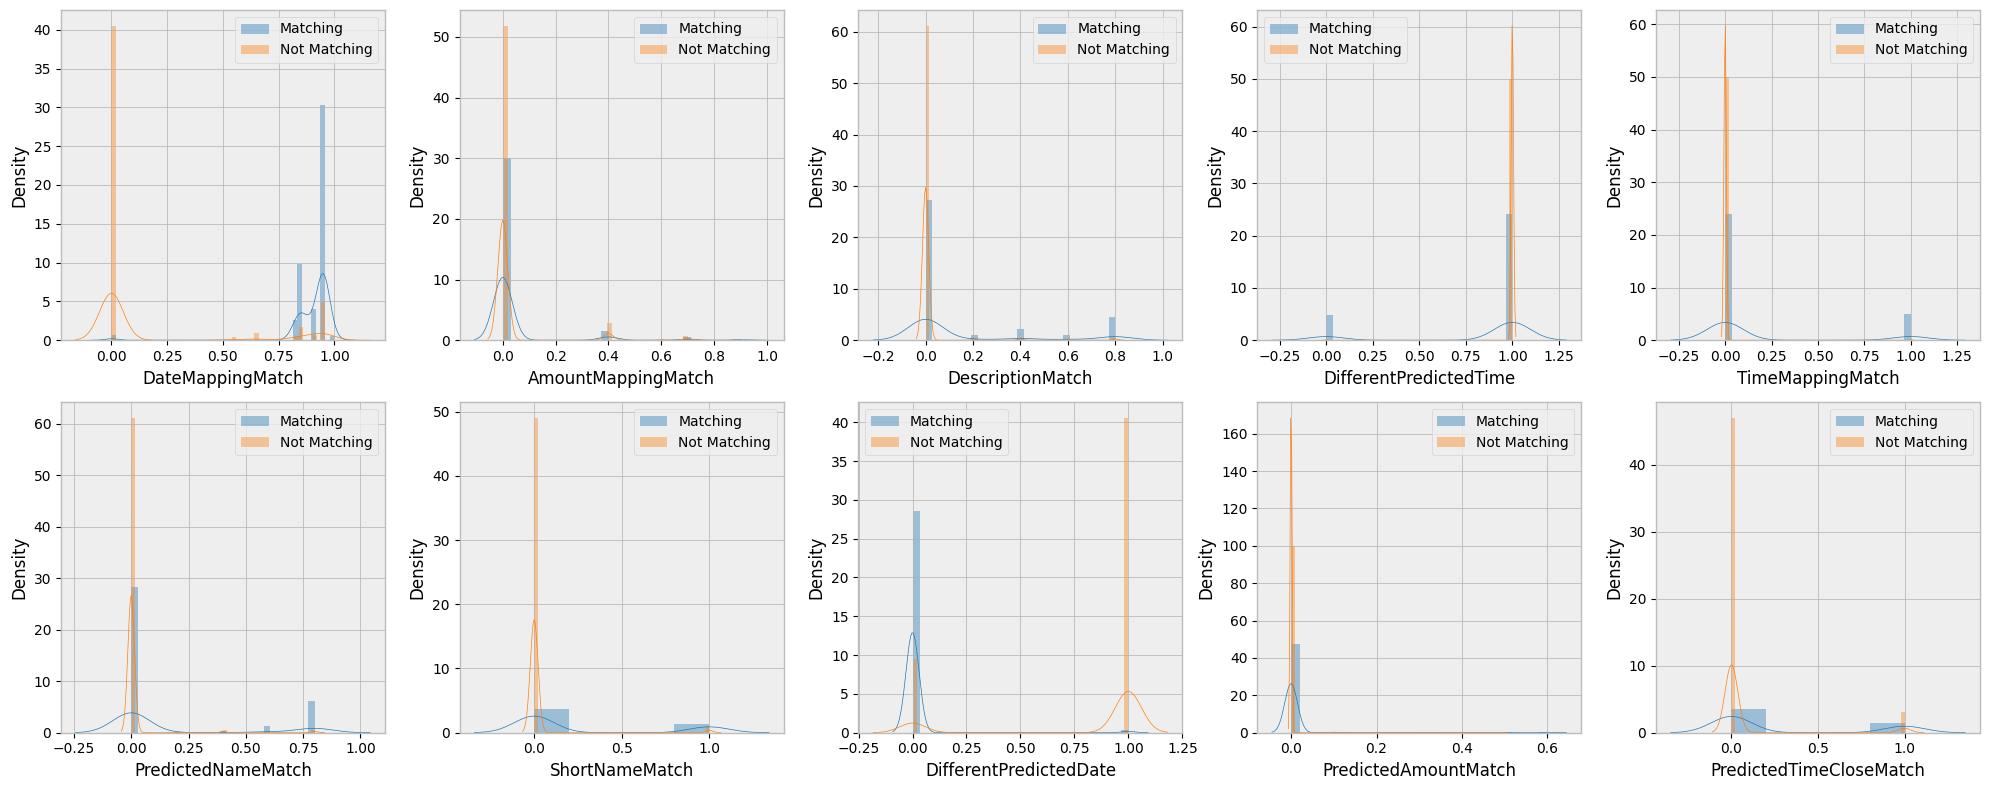

In [17]:
match_df = interim_data_df[interim_data_df['target'] == 1]
notmatch_df = interim_data_df[interim_data_df['target'] == 0]
feature_columns = interim_data_df.columns.tolist()[4:-1]

def plot_features_dist(match_data: pd.DataFrame, notmatch_data: pd.DataFrame, _features_col_list: list):
  
  plt.rcParams['figure.figsize'] = 20, 8;
  fig, axes = plt.subplots(2,5)

  i = j = 0
  for _col in _features_col_list:
      ax = axes[i][j]
      sns.distplot(match_data[_col],label='Matching',ax=ax);
      sns.distplot(notmatch_data[_col],label='Not Matching',ax=ax);
      ax.legend(loc='best')

      j += 1
      if j == 5:
        i += 1
        j = 0

  plt.tight_layout()
  plt.show()


plot_features_dist(match_data = match_df, notmatch_data = notmatch_df, _features_col_list = feature_columns)

**Observation**

The density distribution of each feature shows the dataset is highly biased.

**Conclusion**

The dataset is highly imbalanced hence both Precision and Recall will be important metrics but the major priority we will consider as to get a high Recall, so that correct matching could be found.

### Step 6 : Train, Validate & Test dataset split

In [18]:
feature_columns = interim_data_df.columns.tolist()[4:]

def dataset_split(data_df: pd. DataFrame, _feature_col: list, _target_col_name: str):

  
  model_data = data_df[_feature_col]
  print(model_data.columns)

  return train_valid_test_split(model_data, _target_col_name, random_state=SEED)
  

X_train, y_train, X_valid, y_valid, X_test, y_test = dataset_split(data_df = interim_data_df, _feature_col = feature_columns, _target_col_name = 'target')


Index(['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch',
       'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch',
       'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch',
       'PredictedTimeCloseMatch', 'target'],
      dtype='object')


**Check the data distribution of Train, Validate and Test dataset splited**

In [19]:
X_split_dist = [X_train.shape, X_valid.shape, X_test.shape]
pd.DataFrame(X_split_dist, columns = ['samples', 'features'], index=['X_train', 'X_valid', 'X_test'])

,samples,features
X_train,9627,10
X_valid,1203,10
X_test,1204,10


In [20]:
y_split_dist = [y_train.shape, y_valid.shape, y_test.shape]
pd.DataFrame(y_split_dist, columns = ['samples'], index=['y_train', 'y_valid', 'y_test'])

,samples
y_train,9627
y_valid,1203
y_test,1204


**Conclusion**

The dataset is splitted in - Train, Validate and Test dataset

### Step 7 : Baseline Classifier

Let's start our journey by creating a baseline classifier using matching vector as features. We'll use **fast_ml** to quickly generate metrics for baseline models. It'll help us in compairing our results. 

In [ ]:
baseline_classifier = all_classifiers(X_train, y_train, X_valid, y_valid, X_test, y_test, 
                                   threshold_by = 'ROC AUC' ,verbose = False)
baseline_classifier.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
Algorithm,AdaBoostClassifier,AdaBoostClassifier,AdaBoostClassifier,BaggingClassifier,BaggingClassifier,BaggingClassifier,ExtraTreesClassifier,ExtraTreesClassifier,ExtraTreesClassifier,GradientBoostingClassifier,GradientBoostingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,HistGradientBoostingClassifier,HistGradientBoostingClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,LogisticRegression,LogisticRegression,LogisticRegression,LogisticRegressionCV,LogisticRegressionCV,LogisticRegressionCV,Perceptron,Perceptron,Perceptron,RidgeClassifier,RidgeClassifier,RidgeClassifier,RidgeClassifierCV,RidgeClassifierCV,RidgeClassifierCV,BernoulliNB,BernoulliNB,BernoulliNB,GaussianNB,GaussianNB,GaussianNB,ComplementNB,ComplementNB,ComplementNB,MultinomialNB,MultinomialNB,MultinomialNB,KNeighborsClassifier,KNeighborsClassifier,KNeighborsClassifier,NearestCentroid,NearestCentroid,NearestCentroid,MLPClassifier,MLPClassifier,MLPClassifier,LinearSVC,LinearSVC,LinearSVC,SVC,SVC,SVC,DecisionTreeClassifier,DecisionTreeClassifier,DecisionTreeClassifier,ExtraTreeClassifier,ExtraTreeClassifier,ExtraTreeClassifier
Run Time,0.57,0.57,0.57,0.29,0.29,0.29,0.64,0.64,0.64,0.56,0.56,0.56,1,1,1,0.66,0.66,0.66,0.37,0.37,0.37,2.59,2.59,2.59,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.23,0.23,0.23,0.23,0.23,0.23,0.22,0.22,0.22,0.23,0.23,0.23,1.91,1.91,1.91,0.01,0.01,0.01,6.29,6.29,6.29,0.03,0.03,0.03,0.82,0.82,0.82,0.22,0.22,0.22,0.23,0.23,0.23
Dataset,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test,train,valid,test
No obs,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204,9627,1203,1204
Threshold,0.5,0.5,0.5,0.05,0.05,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.05,0.05,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.05,0.05,0.05,0.4,0.4,0.4,0.65,0.65,0.65,0.1,0.1,0.1,0.05,0.05,0.05,0.5,0.5,0.5,0.05,0.05,0.05,0.5,0.5,0.5,0.5,0.5,0.5,0.05,0.05,0.05,0.05,0.05,0.05
TP,385,44,46,685,84,81,685,84,80,680,83,78,685,84,81,685,84,81,682,84,82,669,83,81,228,28,23,240,31,24,239,31,24,680,85,82,453,54,48,679,85,82,679,85,82,634,76,71,679,84,82,685,84,81,345,40,42,418,48,45,685,83,78,685,82,79
FP,99,14,12,1377,169,177,1363,173,178,1357,166,173,1418,177,183,1384,174,179,1462,186,187,1334,172,179,36,4,4,55,8,6,55,8,6,1690,222,223,251,32,36,1475,192,192,1618,213,217,1218,157,149,1682,218,221,1461,188,190,87,11,7,114,16,12,1363,169,176,1363,169,176
TN,8839,1104,1109,7561,949,944,7575,945,943,7581,952,948,7520,941,938,7554,944,942,7476,932,934,7604,946,942,8902,1114,1117,8883,1110,1115,8883,1110,1115,7248,896,898,8687,1086,1085,7463,926,929,7320,905,904,7720,961,972,7256,900,900,7477,930,931,8851,1107,1114,8824,1102,1109,7575,949,945,7575,949,945
FN,304,41,37,4,1,2,4,1,3,9,2,5,4,1,2,4,1,2,7,1,1,20,2,2,461,57,60,449,54,59,450,54,59,9,0,1,236,31,35,10,0,1,10,0,1,55,9,12,10,1,1,4,1,2,344,45,41,271,37,38,4,2,5,4,3,4
Accuracy Score,0.958139,0.954281,0.959302,0.856549,0.858687,0.851329,0.858004,0.855362,0.849668,0.858107,0.860349,0.852159,0.85229,0.852037,0.846346,0.855822,0.85453,0.849668,0.847408,0.844555,0.843854,0.859354,0.855362,0.849668,0.948374,0.949293,0.946844,0.947647,0.948462,0.946013,0.947543,0.948462,0.946013,0.823517,0.815461,0.813953,0.949413,0.947

**Conclusion**

Out of 24 different algorithm, a boosting technique model like AdaBoostClassifier performs better than bagging technique models like Randomforest. 

This observation can help us decide which model to choose for deeper training.

### Step 8 : Feature Engineering

Our raw dataset has limited set of features.

- ReceiptIDs, FeatureTransactionIDs and MatchedTransactionIDs are actually group indicators in data, let us identify the receipt-transaction groups in data but dont actually provide additional information. And excluding CompanyId too, we'll be left with 10 features.

**New Features**

We can create additional features with the help of the combination of pre-exist features. This will lead to more featues and more information.
- **combination of 2 :** we can create a new feature from the combination of 2 features
- **combination of 3 :** we can create a new feature from the combination of 3 features

In [21]:
feature_columns = interim_data_df.columns.tolist()[4:-1]
print(feature_columns)

['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch', 'PredictedTimeCloseMatch']


In [22]:

def _combination_variable_feature(data_df: pd.DataFrame, _feature_col: list)-> pd.DataFrame:
  """
  Compute two and three combination of features to expand the training data horizontally
  Return
  ------
  pd.DataFrame
  """
  
  two_feature_variable = list()
  three_feature_varibale = list()

  # sum of two varibale features
  two_combination = combinations(_feature_col, 2)
  for f1, f2 in list(two_combination):
    two_feature_var_name = '_'.join([f1, f2])
    two_feature_variable.append(two_feature_var_name)
    data_df[two_feature_var_name] = data_df[f1] + data_df[f2]

 
  # sum of three variable features
  three_combination = combinations(_feature_col, 3)
  for f1, f2, f3 in list(three_combination):
    three_feature_var_name = '_'.join([f1, f2, f3])
    three_feature_varibale.append(three_feature_var_name)
    data_df[three_feature_var_name] = data_df[f1] + data_df[f2] + data_df[f3]
  
  return data_df
  


transform_data_df = _combination_variable_feature(data_df = interim_data_df[feature_columns], _feature_col = feature_columns)
transform_data_df.shape

(12034, 175)

In [23]:
data_summary(data_df = transform_data_df).transpose()

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,DateMappingMatch_AmountMappingMatch,DateMappingMatch_DescriptionMatch,DateMappingMatch_DifferentPredictedTime,DateMappingMatch_TimeMappingMatch,DateMappingMatch_PredictedNameMatch,DateMappingMatch_ShortNameMatch,DateMappingMatch_DifferentPredictedDate,DateMappingMatch_PredictedAmountMatch,DateMappingMatch_PredictedTimeCloseMatch,AmountMappingMatch_DescriptionMatch,AmountMappingMatch_DifferentPredictedTime,AmountMappingMatch_TimeMappingMatch,AmountMappingMatch_PredictedNameMatch,AmountMappingMatch_ShortNameMatch,AmountMappingMatch_DifferentPredictedDate,AmountMappingMatch_PredictedAmountMatch,AmountMappingMatch_PredictedTimeCloseMatch,DescriptionMatch_DifferentPredictedTime,DescriptionMatch_TimeMappingMatch,DescriptionMatch_PredictedNameMatch,DescriptionMatch_ShortNameMatch,DescriptionMatch_DifferentPredictedDate,DescriptionMatch_PredictedAmountMatch,DescriptionMatch_PredictedTimeCloseMatch,DifferentPredictedTime_TimeMappingMatch,DifferentPredictedTime_PredictedNameMatch,DifferentPredictedTime_ShortNameMatch,DifferentPredictedTime_DifferentPredictedDate,DifferentPredictedTime_PredictedAmountMatch,DifferentPredictedTime_PredictedTimeCloseMatch,...,DescriptionMatch_ShortNameMatch_PredictedAmountMatch,DescriptionMatch_ShortNameMatch_PredictedTimeCloseMatch,DescriptionMatch_DifferentPredictedDate_PredictedAmountMatch,DescriptionMatch_DifferentPredictedDate_PredictedTimeCloseMatch,DescriptionMatch_PredictedAmountMatch_PredictedTimeCloseMatch,DifferentPredictedTime_TimeMappingMatch_PredictedNameMatch,DifferentPredictedTime_TimeMappingMatch_ShortNameMatch,DifferentPredictedTime_TimeMappingMatch_DifferentPredictedDate,DifferentPredictedTime_TimeMappingMatch_PredictedAmountMatch,DifferentPredictedTime_TimeMappingMatch_PredictedTimeCloseMatch,DifferentPredictedTime_PredictedNameMatch_ShortNameMatch,DifferentPredictedTime_PredictedNameMatch_DifferentPredictedDate,DifferentPredictedTime_PredictedNameMatch_PredictedAmountMatch,DifferentPredictedTime_PredictedNameMatch_PredictedTimeCloseMatch,DifferentPredictedTime_ShortNameMatch_DifferentPredictedDate,DifferentPredictedTime_ShortNameMatch_PredictedAmountMatch,DifferentPredictedTime_ShortNameMatch_PredictedTimeCloseMatch,DifferentPredictedTime_DifferentPredictedDate_PredictedAmountMatch,DifferentPredictedTime_DifferentPredictedDate_PredictedTimeCloseMatch,DifferentPredictedTime_PredictedAmountMatch_PredictedTimeCloseMatch,TimeMappingMatch_PredictedNameMatch_ShortNameMatch,TimeMappingMatch_PredictedNameMatch_DifferentPredictedDate,TimeMappingMatch_PredictedNameMatch_PredictedAmountMatch,TimeMappingMatch_PredictedNameMatch_PredictedTimeCloseMatch,TimeMappingMatch_ShortNameMatch_DifferentPredictedDate,TimeMappingMatch_ShortNameMatch_PredictedAmountMatch,TimeMappingMatch_ShortNameMatch_PredictedTimeCloseMatch,TimeMappingMatch_DifferentPredictedDate_PredictedAmountMatch,TimeMappingMatch_DifferentPredictedDate_PredictedTimeCloseMatch,TimeMappingMatch_PredictedAmountMatch_PredictedTimeCloseMatch,PredictedNameMatch_ShortNameMatch_DifferentPredictedDate,PredictedNameMatch_ShortNameMatch_PredictedAmountMatch,PredictedNameMatch_ShortNameMatch_PredictedTimeCloseMatch,PredictedNameMatch_DifferentPredictedDate_PredictedAmountMatch,PredictedNameMatch_DifferentPredictedDate_PredictedTimeCloseMatch,PredictedNameMatch_PredictedAmountMatch_PredictedTimeCloseMatch,ShortNameMatch_DifferentPredictedDate_PredictedAmountMatch,ShortNameMatch_DifferentPredictedDate_PredictedTimeCloseMatch,ShortNameMatch_PredictedAmountMatch_PredictedTimeCloseMatch,DifferentPredictedDate_PredictedAmountMatch_PredictedTimeCloseMatch
data_type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,floa

**Conclusion**

As we can see, from only 10 features from raw dataset, now we have 175 features. This is a good start for model building

### Step 9 : Train, Validate and Test re-split dataset

Now, Split the updated dataset with 175 features in - Train, Validate and Test dataset

In [24]:
"""Add the `target` variable"""

transform_data_df['target'] = interim_data_df['target']
transform_data_df.shape

(12034, 176)

In [25]:
"""Split the data"""
X_train, y_train, X_valid, y_valid, X_test, y_test = dataset_split(data_df = transform_data_df, 
                                                                   _feature_col = transform_data_df.columns.tolist(), _target_col_name = 'target')

Index(['DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch',
       'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch',
       'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch',
       'PredictedTimeCloseMatch',
       ...
       'PredictedNameMatch_ShortNameMatch_PredictedAmountMatch',
       'PredictedNameMatch_ShortNameMatch_PredictedTimeCloseMatch',
       'PredictedNameMatch_DifferentPredictedDate_PredictedAmountMatch',
       'PredictedNameMatch_DifferentPredictedDate_PredictedTimeCloseMatch',
       'PredictedNameMatch_PredictedAmountMatch_PredictedTimeCloseMatch',
       'ShortNameMatch_DifferentPredictedDate_PredictedAmountMatch',
       'ShortNameMatch_DifferentPredictedDate_PredictedTimeCloseMatch',
       'ShortNameMatch_PredictedAmountMatch_PredictedTimeCloseMatch',
       'DifferentPredictedDate_PredictedAmountMatch_PredictedTimeCloseMatch',
       'target'],
      dtype='object', length=176)


In [26]:
"""Check X split distribution"""
X_split_dist = [X_train.shape, X_valid.shape, X_test.shape]
pd.DataFrame(X_split_dist, columns = ['samples', 'features'], index=['X_train', 'X_valid', 'X_test'])

,samples,features
X_train,9627,175
X_valid,1203,175
X_test,1204,175


In [27]:
"""Check y split distribution"""
y_split_dist = [y_train.shape, y_valid.shape, y_test.shape]
pd.DataFrame(y_split_dist, columns = ['samples'], index=['y_train', 'y_valid', 'y_test'])

,samples
y_train,9627
y_valid,1203
y_test,1204


**Conclusion**

This split dataset with 175 features will be used in the model training.

### Train Individual Models


We will train our features on a bagging technique model and a boosting technique model.

#### Random Forest - Bagging Technique

In [28]:
"""Define a model"""
rfm_model = RandomForestClassifier(n_estimators=1000, class_weight={1:2}, random_state=SEED)

In [29]:
"""Execute the model"""
execute_model(rfm_model, 'Random Forest', X_train, y_train, X_valid, y_valid, X_test, y_test, 
              eval_metrics='ROC AUC Score')

,Algorithm,Run Time,Dataset,No obs,Threshold,TP,FP,TN,FN,Accuracy Score,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,Random Forest,7.47,train,9627,0.1,685,1375,7563,4,0.856757,0.332524,0.994194,0.498363,0.920178
1,Random Forest,7.47,valid,1203,0.1,84,171,947,1,0.857024,0.329412,0.988235,0.494118,0.917642
2,Random Forest,7.47,test,1204,0.1,81,178,943,2,0.850498,0.312741,0.975904,0.473684,0.908558


In [30]:
"""Feature Importance"""
important_fi = get_fi(rfm_model, X_train).transpose()
important_fi

,DateMappingMatch_AmountMappingMatch_PredictedNameMatch,DateMappingMatch_AmountMappingMatch,DateMappingMatch_AmountMappingMatch_DescriptionMatch,DateMappingMatch_PredictedNameMatch_PredictedAmountMatch,DateMappingMatch_TimeMappingMatch_PredictedNameMatch,DateMappingMatch_PredictedNameMatch,DateMappingMatch_AmountMappingMatch_TimeMappingMatch,DateMappingMatch,DateMappingMatch_AmountMappingMatch_PredictedAmountMatch,DateMappingMatch_DescriptionMatch_PredictedAmountMatch,DateMappingMatch_DescriptionMatch_TimeMappingMatch,DateMappingMatch_DescriptionMatch,DateMappingMatch_DescriptionMatch_ShortNameMatch,DateMappingMatch_TimeMappingMatch,DateMappingMatch_PredictedAmountMatch,DescriptionMatch_TimeMappingMatch_ShortNameMatch,DateMappingMatch_DescriptionMatch_PredictedNameMatch,DateMappingMatch_TimeMappingMatch_PredictedAmountMatch,DateMappingMatch_DifferentPredictedTime_TimeMappingMatch,DescriptionMatch_ShortNameMatch_PredictedTimeCloseMatch,DescriptionMatch_TimeMappingMatch_PredictedNameMatch,TimeMappingMatch_PredictedNameMatch_ShortNameMatch,DateMappingMatch_PredictedNameMatch_ShortNameMatch,DateMappingMatch_TimeMappingMatch_ShortNameMatch,DescriptionMatch_PredictedNameMatch_ShortNameMatch,DateMappingMatch_ShortNameMatch,DateMappingMatch_AmountMappingMatch_ShortNameMatch,DescriptionMatch_TimeMappingMatch_PredictedAmountMatch,DescriptionMatch_ShortNameMatch_PredictedAmountMatch,DescriptionMatch_DifferentPredictedDate_PredictedAmountMatch,DescriptionMatch_ShortNameMatch,DescriptionMatch_PredictedNameMatch_PredictedTimeCloseMatch,DateMappingMatch_ShortNameMatch_PredictedAmountMatch,DescriptionMatch_TimeMappingMatch,PredictedNameMatch_ShortNameMatch_PredictedTimeCloseMatch,TimeMappingMatch_PredictedNameMatch_PredictedAmountMatch,TimeMappingMatch_PredictedNameMatch,PredictedNameMatch_DifferentPredictedDate,AmountMappingMatch_TimeMappingMatch_PredictedNameMatch,DescriptionMatch_TimeMappingMatch_DifferentPredictedDate,...,AmountMappingMatch_DescriptionMatch_DifferentPredictedTime,DifferentPredictedTime_TimeMappingMatch_PredictedNameMatch,AmountMappingMatch_DescriptionMatch,TimeMappingMatch_DifferentPredictedDate_PredictedAmountMatch,DifferentPredictedTime_PredictedTimeCloseMatch,PredictedNameMatch,AmountMappingMatch,AmountMappingMatch_DifferentPredictedTime,AmountMappingMatch_TimeMappingMatch,AmountMappingMatch_DifferentPredictedTime_TimeMappingMatch,DifferentPredictedTime_PredictedAmountMatch_PredictedTimeCloseMatch,AmountMappingMatch_DifferentPredictedTime_PredictedAmountMatch,AmountMappingMatch_DifferentPredictedDate_PredictedTimeCloseMatch,DifferentPredictedTime_DifferentPredictedDate_PredictedAmountMatch,ShortNameMatch_DifferentPredictedDate,TimeMappingMatch_PredictedAmountMatch_PredictedTimeCloseMatch,AmountMappingMatch_PredictedAmountMatch,DifferentPredictedTime_TimeMappingMatch_ShortNameMatch,AmountMappingMatch_PredictedAmountMatch_PredictedTimeCloseMatch,ShortNameMatch_DifferentPredictedDate_PredictedTimeCloseMatch,DifferentPredictedTime_ShortNameMatch_DifferentPredictedDate,AmountMappingMatch_PredictedTimeCloseMatch,DifferentPredictedTime_ShortNameMatch_PredictedTimeCloseMatch,TimeMappingMatch,DifferentPredictedTime_PredictedAmountMatch,TimeMappingMatch_PredictedTimeCloseMatch,TimeMappingMatch_DifferentPredictedDate_PredictedTimeCloseMatch,PredictedAmountMatch_PredictedTimeCloseMatch,DifferentPredictedTime_TimeMappingMatch_PredictedTimeCloseMatch,PredictedAmountMatch,ShortNameMatch,DifferentPredictedDate_PredictedAmountMatch_PredictedTimeCloseMatch,DifferentPredictedTime_ShortNameMatch,DifferentPredictedDate_PredictedTimeCloseMatch,DifferentPredictedTime_TimeMappingMatch_PredictedAmountMatch,PredictedTimeCloseMatch,TimeMappingMatch_DifferentPredictedDate,DifferentPredictedTime_TimeMappingMatch_DifferentPredictedDate,DifferentPredictedTime_TimeMappingMatch,DifferentPredictedTime
feature_imp,0.052222,0.045492,0.036813,0.036360,0.033092,0.032469,0.032389,0.032065,0.030689,0.027392,0.026343,0.025776,0.024966,0.023785,0.023321,0.0226

After training the random forest model, we'll update the predicted values by calculating the predicted probability. In this way, instead of returning a fixed label like `0` or `1`. It will predict the probability of each label.

In [31]:
"""Predicted Probability Distribution
0 - Not Matched
1 - Matched
"""
y_pred = pd.DataFrame(rfm_model.predict_proba(transform_data_df[X_train.columns.tolist()]))
y_pred.rename(columns = {0: 'not_match_pred_prob', 1: 'match_pred_prob'}, inplace = True)
y_pred.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11994,11995,11996,11997,11998,11999,12000,12001,12002,12003,12004,12005,12006,12007,12008,12009,12010,12011,12012,12013,12014,12015,12016,12017,12018,12019,12020,12021,12022,12023,12024,12025,12026,12027,12028,12029,12030,12031,12032,12033
not_match_pred_prob,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.712319,0.712319,0.04425,0.74615,0.74615,0.74615,0.74615,0.74615,0.74615,1.0,1.0,1.0,1.0,0.357827,0.357827,...,0.764742,0.973558,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.051314,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.578796
match_pred_prob,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287681,0.287681,0.95575,0.25385,0.25385,0.25385,0.25385,0.25385,0.25385,0.0,0.0,0.0,0.0,0.642173,0.642173,...,0.235258,0.026442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.421204


Convert from predicted probability to fixed label if predicted probability is above a fixed threshold. Here, we set this threshold to `0.1`

In [32]:
"""Add Predicted Probability Results with Original Data"""

rfm_model_data_pred = pd.concat([interim_data_df, y_pred['match_pred_prob']], axis=1)
rfm_model_data_pred['match_pred_target'] = np.where(rfm_model_data_pred['match_pred_prob'] > 0.1, 1, 0)

rfm_model_data_pred = rfm_model_data_pred.sort_values(by = ['receipt_id', 'match_pred_prob'], ascending=[True, False])

In [33]:
"""Preview at the sample of the data with `receipt_id` = '10,001'"""
rfm_model_data_pred[rfm_model_data_pred['receipt_id']=='10,001']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target
25,"10,001",10000,"10,605","10,605",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.287681,1
26,"10,001",10000,"10,605","10,606",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.287681,1
20,"10,001",10000,"10,605","10,596",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0
21,"10,001",10000,"10,605","10,597",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0
22,"10,001",10000,"10,605","10,598",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0
23,"10,001",10000,"10,605","10,599",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0
24,"10,001",10000,"10,605","10,600",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0


In [34]:
"""Assign ranks to each `match_pred_target`"""
rfm_model_data_pred['match_prob_rank'] = rfm_model_data_pred.groupby('receipt_id')['match_pred_prob'].rank(method='min', ascending=False)
rfm_model_data_pred['pred_target_rank'] = rfm_model_data_pred['match_pred_target'] * rfm_model_data_pred['match_prob_rank']

# Set all top ranked predicted probability as '1' and rest '0'
rfm_model_data_pred['pred_target_rank_one'] = np.where(rfm_model_data_pred['pred_target_rank'] == 1, 1, 0) 

In [35]:
# Preview the sample data with `receipt_id` = '10,001'
rfm_model_data_pred[rfm_model_data_pred['receipt_id']=='10,001']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target,match_prob_rank,pred_target_rank,pred_target_rank_one
25,"10,001",10000,"10,605","10,605",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.287681,1,1.0,1.0,1
26,"10,001",10000,"10,605","10,606",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.287681,1,1.0,1.0,1
20,"10,001",10000,"10,605","10,596",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0,3.0,0.0,0
21,"10,001",10000,"10,605","10,597",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0,3.0,0.0,0
22,"10,001",10000,"10,605","10,598",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0,3.0,0.0,0
23,"10,001",10000,"10,605","10,599",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0,3.0,0.0,0
24,"10,001",10000,"10,605","10,600",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,0,3.0,0.0,0


**Observation**
 
 - The original dataset has one matching for receipt_id = 10001 i.e with feature_transaction_id = 10605. Whereas, our model has given equal probability to 2 feature_transaction_id that is 10605, 10606. Out of which one is correct i.e. 10605 and another incorrect i.e. 10606



|  original target | predicted target  |   
|------------------|-------------------|
| 10605  | 10605  |   
|        | 10606  |

In [ ]:
# Preview the sample data with `receipt_id` = '50,013'
rfm_model_data_pred[rfm_model_data_pred['receipt_id']=='50,013']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target,match_prob_rank,pred_target_rank,pred_target_rank_one
10699,"50,013",50000,"50,285","50,285",0.9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0.921742,1,1.0,1.0,1
10698,"50,013",50000,"50,285","50,284",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.287681,1,2.0,2.0,0
10700,"50,013",50000,"50,285","50,286",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.287681,1,2.0,2.0,0


**Observation**
 
 - The original dataset has one matching for receipt_id = 50013 i.e with feature_transaction_id = 50285. And our also model has given high probability to feature_transaction_id = 50285 



|  original target | predicted target  |   
|------------------|-------------------|
| 50285  | 50285 |   


In [36]:
"""Contingency table which shows the top distribution of ranks assigned to each target"""
pd.pivot_table(rfm_model_data_pred, index=['company_id', 'target'], values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

pred_target_rank    0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0
company_id target                                              
10000      0       1828  203  111   41    5    1    3    3    2
           1          0  145    7    1    1    0    0    0    0
20000      0       1983   61  139   39    7    1    0    0    0
           1          1  136    5    2    1    0    0    0    0
30000      0       3968  275  304   73   40    7    5    1    3
           1          2  228   13    7    0    0    0    0    0
40000      0        709   70   71   22    2    1    0    1    0
           1          4  113    3    3    0    0    0    0    0
50000      0        965   56  143   20   11    3    0    0    0
           1          0  178    6    0    0    1    0    0    0

**Observation**

The above contingency table shows the distribution of each rank for each company_id. We can see as we move towards the higher rank the values decreases that's a good sign as our end goal is to shift values in higher ranks to lower ranks.

**Confusion Matrix where Target = 1**

False Negative are in main focus

In [37]:

def confusion_matrix_each_company(data_df: pd.DataFrame, _companies: list):
  for comp in _companies:
    _comp_data = data_df.query(f"company_id=={comp}")
    _comp_confusion = confusion_matrix(_comp_data['target'], _comp_data['pred_target_rank_one'])
    _comp_recall = recall_score(_comp_data['target'], _comp_data['pred_target_rank_one'])
    print(f"Confusion Matrix for Company {comp}")
    print(_comp_confusion)
    print(f"Recall for Company {comp} = {_comp_recall}")
   
confusion_matrix_each_company(data_df = rfm_model_data_pred.query("target==1"), _companies = rfm_model_data_pred['company_id'].unique().tolist())


Confusion Matrix for Company 10000
[[  0   0]
 [  9 145]]
Recall for Company 10000 = 0.9415584415584416
Confusion Matrix for Company 20000
[[  0   0]
 [  9 136]]
Recall for Company 20000 = 0.9379310344827586
Confusion Matrix for Company 30000
[[  0   0]
 [ 22 228]]
Recall for Company 30000 = 0.912
Confusion Matrix for Company 40000
[[  0   0]
 [ 10 113]]
Recall for Company 40000 = 0.9186991869918699
Confusion Matrix for Company 50000
[[  0   0]
 [  7 178]]
Recall for Company 50000 = 0.9621621621621622


In [38]:
"""Contingency Table for target==1"""
pd.pivot_table(rfm_model_data_pred.query("target==1"), index = ['company_id', 'target'] , values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

,pred_target_rank,0.0,1.0,2.0,3.0,4.0,5.0
company_id,target,,,,,,
10000,1,0,145,7,1,1,0
20000,1,1,136,5,2,1,0
30000,1,2,228,13,7,0,0
40000,1,4,113,3,3,0,0
50000,1,0,178,6,0,0,1


**Observation**

The above table shows the misclassifications. Like in first row it explains - 
- for company_id=10000: 145 receipts ids correctly classified with rank 1
- for company_id=10000: 7 receipts ids correctly classified with rank 2. But we want it too to se classified under rank 1.

We can perform better by using a boosting technique algorithm.

In [ ]:
"""Preview of sample dataset that made all wrong prediction"""
rfm_model_data_pred[rfm_model_data_pred['receipt_id']=='30,198']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target,match_prob_rank,pred_target_rank,pred_target_rank_one
7264,"30,198",30000,"30,137","30,137",0.0,0.0,0.8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.06923,0,1.0,0.0,0
7248,"30,198",30000,"30,137","30,002",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7249,"30,198",30000,"30,137","30,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7250,"30,198",30000,"30,137","30,012",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7251,"30,198",30000,"30,137","30,037",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7252,"30,198",30000,"30,137","30,047",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7253,"30,198",30000,"30,137","30,059",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7254,"30,198",30000,"30,137","30,071",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7255,"30,198",30000,"30,137","30,077",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0
7256,"30,198",30000,"30,137","30,078",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.00000,0,2.0,0.0,0


**Observation**

Correct match has highest probability compared to other but below threshold level i.e. 0.1

#### XGBoost - Boosting Techniques

**XGBoost** has a lot of hyperparameters, parameters that we have to manual configure and are not determined by **XGBoost** itself, including *max_depth*, the maximum tree depth, *learning_rate*, the learning rate, or *gamma*, the parameter that encourages pruning, and *reg_lambda*, the regularization parameter lambda.

Since we have many parameters to optimize, we will use GridSearchCV(). We specify a bunch of potential values for the hyperparameters and **GridSearchCV()** tests all possible combinations of the parameters for us.

In [39]:
X = transform_data_df[transform_data_df.columns[:-1]]
y = transform_data_df['target']

In [40]:
"""Resplit the dataset"""
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [41]:
X.shape, y.shape

((10830, 175), (10830,))

In [42]:
X_test.shape, y_test.shape

((1204, 175), (1204,))

**Note :**

When you have imbalanced data, the XGBoost manual says...
If you only care about the overall performance metric (AUC) of your prediction
then in that case -


*   Balance the positive and negative weights via scale_pos_weight
*   Use AUC for evaluation

I ran GridSearchCV sequentially  on subsets of paramter options 

**ROUND 1**
```
param_grid {
  'max_depth': [3, 4, 5],
  'learning_rate': [0.1, 0.01, 0.05],
  'gamma': [0, 0.25, 1.0],
  'reg_lambda': [0, 1.0, 10.0],
  'scale_pos_weight': [1, 2, 3]
}
```

**ROUND 2**
```
param_grid {
  'max_depth': [4],
  'learning_rate': [0.1, 0.5, 1],
  'gamma': [0.25],
  'reg_lambda': [10, 20, 100],
  'scale_pos_weight': [3]
}
```

**ROUND 3**
```
param_grid {
  'max_depth': [3, 4, 5],
  'learning_rate': [0.1, 0.01, 0.05],
  'gamma': [0, 0.25, 1.0],
  'reg_lambda': [0, 1.0, 10.0],
  'scale_pos_weight': [1, 2, 3]
}
```

**Note:**

To speed up cross validation, and to further prevent overfitting. We are only using a random subset of data (90%) and are only  using  a random subset of features (columns) (50%) per tree.

```
optimal_params = GridSearchCV(
      estimator= XGBClassifier(
              objective='binary:logistic',
              seed = SEED,
              subsample = 0.9,
              colsample_bytree=0.5),
      param_grid = param_grid,
      scoring = 'roc_auc',
      verbose = 0,
      n_jobs = 10,
      cv = 3
)
```


After testing all possible combinations of the potential parameter values with Cross Validation, we find



- gamma = 0.25
- learn_rate = 0.1
- max_depth = 4
- reg_lambda = 10



In [43]:

xgboost_model2 = XGBClassifier(
              objective='binary:logistic',
              seed = SEED,
              gamma = 0.25,
              learn_rate = 0.1,
              reg_lambda = 10,
              max_depth = 4,
              scale_pos_weight = 4,
              subsample = 0.9,
              colsample_bytree=0.5,
              n_extimator=500)

In [44]:
xgboost_model2.fit(X, y,
                   verbose=True,
                   early_stopping_rounds = 30,
                   eval_metric = 'auc',
                   eval_set = [(X_test, y_test)])

[0]	validation_0-auc:0.951743
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.952048
[2]	validation_0-auc:0.953414
[3]	validation_0-auc:0.953551
[4]	validation_0-auc:0.953583
[5]	validation_0-auc:0.954413
[6]	validation_0-auc:0.954555
[7]	validation_0-auc:0.954655
[8]	validation_0-auc:0.954771
[9]	validation_0-auc:0.954655
[10]	validation_0-auc:0.960343
[11]	validation_0-auc:0.960448
[12]	validation_0-auc:0.95967
[13]	validation_0-auc:0.959638
[14]	validation_0-auc:0.959533
[15]	validation_0-auc:0.959586
[16]	validation_0-auc:0.959691
[17]	validation_0-auc:0.959738
[18]	validation_0-auc:0.96468
[19]	validation_0-auc:0.964779
[20]	validation_0-auc:0.964785
[21]	validation_0-auc:0.96407
[22]	validation_0-auc:0.963912
[23]	validation_0-auc:0.963954
[24]	validation_0-auc:0.963954
[25]	validation_0-auc:0.963959
[26]	validation_0-auc:0.963938
[27]	validation_0-auc:0.964023
[28]	validation_0-auc:0.964001
[29]	validation_0-auc:0.964175
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learn_rate=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100,
              n_extimator=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=4, seed=2021, silent=None,
              subsample=0.9, verbosity=1)

In [45]:
"""Predicted Probability Distribution
0 - Not Matched
1 - Matched
"""
y_pred = pd.DataFrame(xgboost_model2.predict_proba(transform_data_df[X_test.columns.tolist()]))
y_pred.rename(columns = {0: 'not_match_pred_prob', 1: 'match_pred_prob'}, inplace = True)
y_pred.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11994,11995,11996,11997,11998,11999,12000,12001,12002,12003,12004,12005,12006,12007,12008,12009,12010,12011,12012,12013,12014,12015,12016,12017,12018,12019,12020,12021,12022,12023,12024,12025,12026,12027,12028,12029,12030,12031,12032,12033
not_match_pred_prob,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.570555,0.570555,0.123332,0.570555,0.570555,0.570555,0.570555,0.570555,0.570555,0.938807,0.938807,0.938807,0.938807,0.234137,0.234137,...,0.617367,0.931467,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.103072,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.938807,0.45442
match_pred_prob,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.429445,0.429445,0.876668,0.429445,0.429445,0.429445,0.429445,0.429445,0.429445,0.061193,0.061193,0.061193,0.061193,0.765863,0.765863,...,0.382633,0.068533,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.896928,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.061193,0.54558


In [46]:
"""Add Predicted Probability Results with Interim Data"""

xgboost_model2_data_pred = pd.concat([interim_data_df, y_pred['match_pred_prob']], axis=1)
xgboost_model2_data_pred['match_pred_target'] = np.where(xgboost_model2_data_pred['match_pred_prob'] > 0.1, 1, 0)

xgboost_model2_data_pred = xgboost_model2_data_pred.sort_values(by = ['receipt_id', 'match_pred_prob'], ascending=[True, False])

In [47]:
"""Preview at the sample of the data with `receipt_id` = '10,001'"""
xgboost_model2_data_pred[xgboost_model2_data_pred['receipt_id']=='10,001']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target
25,"10,001",10000,"10,605","10,605",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.429445,1
26,"10,001",10000,"10,605","10,606",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.429445,1
20,"10,001",10000,"10,605","10,596",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0
21,"10,001",10000,"10,605","10,597",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0
22,"10,001",10000,"10,605","10,598",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0
23,"10,001",10000,"10,605","10,599",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0
24,"10,001",10000,"10,605","10,600",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0


In [48]:
"""Assign ranks to each `match_pred_target`"""
xgboost_model2_data_pred['match_prob_rank'] = xgboost_model2_data_pred.groupby('receipt_id')['match_pred_prob'].rank(method='min', ascending=False)
xgboost_model2_data_pred['pred_target_rank'] = xgboost_model2_data_pred['match_pred_target'] * xgboost_model2_data_pred['match_prob_rank']

# Set all top ranked predicted probability as '1' and rest '0'
xgboost_model2_data_pred['pred_target_rank_one'] = np.where(xgboost_model2_data_pred['pred_target_rank'] == 1, 1, 0) 

In [49]:
"""Preview at the sample of the data with `receipt_id` = '10,001'"""
xgboost_model2_data_pred[xgboost_model2_data_pred['receipt_id']=='10,001']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target,match_prob_rank,pred_target_rank,pred_target_rank_one
25,"10,001",10000,"10,605","10,605",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.429445,1,1.0,1.0,1
26,"10,001",10000,"10,605","10,606",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.429445,1,1.0,1.0,1
20,"10,001",10000,"10,605","10,596",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,3.0,0.0,0
21,"10,001",10000,"10,605","10,597",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,3.0,0.0,0
22,"10,001",10000,"10,605","10,598",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,3.0,0.0,0
23,"10,001",10000,"10,605","10,599",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,3.0,0.0,0
24,"10,001",10000,"10,605","10,600",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,3.0,0.0,0


In [50]:
# Preview the sample data with `receipt_id` = '50,013'
xgboost_model2_data_pred[xgboost_model2_data_pred['receipt_id']=='50,013']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target,match_prob_rank,pred_target_rank,pred_target_rank_one
10699,"50,013",50000,"50,285","50,285",0.9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0.850716,1,1.0,1.0,1
10698,"50,013",50000,"50,285","50,284",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.429445,1,2.0,2.0,0
10700,"50,013",50000,"50,285","50,286",0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.429445,1,2.0,2.0,0


In [51]:
"""Contingency table which shows the top distribution of ranks assigned to each target"""
pd.pivot_table(xgboost_model2_data_pred, index=['company_id', 'target'], values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

pred_target_rank   0.0   1.0   2.0   3.0   4.0   ...  6.0   7.0   8.0   9.0   10.0
company_id target                                ...                              
10000      0       1780   199   114    51    22  ...    11     4     1     7     1
           1          0   141    10     2     1  ...     0     0     0     0     0
20000      0       1954    61   144    49     9  ...     1     0     0     0     0
           1          1   134     6     4     0  ...     0     0     0     0     0
30000      0       3901   297   307    90    49  ...    12     1     4     1     0
           1          1   229    12     8     0  ...     0     0     0     0     0
40000      0        673    86    75    23    12  ...     0     1     1     1     0
           1          1   111     8     3     0  ...     0     0     0     0     0
50000      0        931    58   152    34    10  ...     1     1     0     0     0
           1          0   179     5     0     0  ...     0     0     0     0     0

[10 rows x 11 columns]

In [52]:
"""Company Ids wise Confusion Matrix where target==1"""   
confusion_matrix_each_company(data_df = xgboost_model2_data_pred.query("target==1"),
                              _companies = xgboost_model2_data_pred['company_id'].unique().tolist())


Confusion Matrix for Company 10000
[[  0   0]
 [ 13 141]]
Recall for Company 10000 = 0.9155844155844156
Confusion Matrix for Company 20000
[[  0   0]
 [ 11 134]]
Recall for Company 20000 = 0.9241379310344827
Confusion Matrix for Company 30000
[[  0   0]
 [ 21 229]]
Recall for Company 30000 = 0.916
Confusion Matrix for Company 40000
[[  0   0]
 [ 12 111]]
Recall for Company 40000 = 0.9024390243902439
Confusion Matrix for Company 50000
[[  0   0]
 [  6 179]]
Recall for Company 50000 = 0.9675675675675676


In [53]:
"""Contingency Table for target==1"""
pd.pivot_table(xgboost_model2_data_pred.query("target==1"), index = ['company_id', 'target'] , values = 'receipt_id', columns = 'pred_target_rank', 
               aggfunc='count', fill_value=0)

,pred_target_rank,0.0,1.0,2.0,3.0,4.0,5.0
company_id,target,,,,,,
10000,1,0,141,10,2,1,0
20000,1,1,134,6,4,0,0
30000,1,1,229,12,8,0,0
40000,1,1,111,8,3,0,0
50000,1,0,179,5,0,0,1


Obervations:
- Here we can see the number of receipts in rank 2,3,4,5 buckets where they should have been in rank 1 ideally
- Few good things that works in favor of the solution
    - Most of the time we have picked the right receipts in top 5 ranks
    - In maximum number of cases correctly matched receipts are in rank = 1 category
    - Very few goes beyond rank 2
    - This result is quite better than our random forest result

In [54]:
"""Preview of sample dataset that made all wrong prediction"""
xgboost_model2_data_pred[xgboost_model2_data_pred['receipt_id']=='30,198']

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,target,match_pred_prob,match_pred_target,match_prob_rank,pred_target_rank,pred_target_rank_one
7264,"30,198",30000,"30,137","30,137",0.0,0.0,0.8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.132322,1,1.0,1.0,1
7248,"30,198",30000,"30,137","30,002",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7249,"30,198",30000,"30,137","30,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7250,"30,198",30000,"30,137","30,012",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7251,"30,198",30000,"30,137","30,037",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7252,"30,198",30000,"30,137","30,047",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7253,"30,198",30000,"30,137","30,059",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7254,"30,198",30000,"30,137","30,071",0.0,0.4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7255,"30,198",30000,"30,137","30,077",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0
7256,"30,198",30000,"30,137","30,078",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.061193,0,2.0,0.0,0


**Observation**

For above ```receipt_id = 30,198``` 
- Random Forest model were not able to classify it correctly, whereas
- XGBoost model classify it correctly.

**Conclusion**

We can see the improvement, hence we can go forward with XGBoost model.

### Save the model

In [55]:
pickle.dump(xgboost_model2, open('xgboost_model2.sav', 'wb'))

## Generate Prediction

In [56]:
def generate_prediction(input_data: pd.DataFrame, max_ranks:int, _threshold:float)->pd.DataFrame:
  """
  Genreate prediction for input dataset
  """
  
  _interim_data = input_data.copy()

  """Feature Engineering"""
  _feature_columns = _interim_data.columns.tolist()[4:]

  _transform_data_df = _combination_variable_feature(data_df = _interim_data[_feature_columns], _feature_col = _feature_columns)

  """Load the model"""
  load_xgboost_model2 = pickle.load(open('xgboost_model2.sav', 'rb'))

  """Predicted Probability Distribution
      0 - Not Matched
      1 - Matched
  """
  y_pred = pd.DataFrame(load_xgboost_model2.predict_proba(_transform_data_df))
  y_pred.rename(columns = {0: 'not_match_pred_prob', 1: 'match_pred_prob'}, inplace = True)

  """Add Predicted Probability Results with Original Data"""

  _xgboost_data_pred = pd.concat([_interim_data, y_pred['match_pred_prob']], axis=1)
  _xgboost_data_pred['match_pred_target'] = np.where(_xgboost_data_pred['match_pred_prob'] > _threshold, 1, 0)

  _xgboost_data_pred = _xgboost_data_pred.sort_values(by = ['receipt_id', 'match_pred_prob'], ascending=[True, False])

  """Assign ranks to each `match_pred_target`"""
  _xgboost_data_pred['match_prob_rank'] = _xgboost_data_pred.groupby('receipt_id')['match_pred_prob'].rank(method='min', ascending=False)
  _xgboost_data_pred['match_prob_rank'] = _xgboost_data_pred['match_pred_target'] * _xgboost_data_pred['match_prob_rank']

  # Set all top ranked predicted probability as '1' and rest '0'
  _xgboost_data_pred['match_prob_rank'] = np.where(_xgboost_data_pred['match_prob_rank'] > max_ranks, 99, _xgboost_data_pred['match_prob_rank'])
  _xgboost_data_pred.drop(columns = ['match_pred_prob', 'match_pred_target'], inplace=True)
  
  return _xgboost_data_pred
  


In [57]:
_xgboost_data_pred_data = generate_prediction(input_data = raw_data_df, max_ranks=5, _threshold=0.1)
_xgboost_data_pred_data.head(10)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,match_prob_rank
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,"10,000",10000,"10,468","10,006",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,"10,000",10000,"10,468","10,008",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,"10,000",10000,"10,468","10,009",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,"10,000",10000,"10,468","10,010",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,"10,000",10000,"10,468","10,011",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [61]:
"""Contingency Table for rank distribution of different company_id"""
pd.pivot_table(_xgboost_data_pred_data, index = ['company_id'] , values = 'receipt_id', columns = 'match_prob_rank', 
               aggfunc='count', fill_value=0)

match_prob_rank,0.0,1.0,2.0,3.0,4.0,5.0,99.0
company_id,,,,,,,
10000,1780,340,124,53,23,7,24
20000,1955,195,150,53,9,12,1
30000,3902,526,319,98,49,14,18
40000,674,197,83,26,12,4,3
50000,931,237,157,34,10,12,2


# The End